In [50]:
%load_ext autoreload
%autoreload 2

In [1]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/paraphrase-distilroberta-base-v1')
embeddings = model.encode(sentences)
print(embeddings)

[[ 0.11292293  0.00787112 -0.06705638 ... -0.01397553 -0.07149326
   0.39829493]
 [-0.02445049  0.16701742 -0.1270483  ...  0.1414244   0.19376723
   0.14391412]]


In [2]:
from dataset import HallucinationDataset
from torch.utils.data import DataLoader

train = HallucinationDataset("data/val/val.model-agnostic.json", "PG")
train_loader = DataLoader(train, batch_size=128)

In [11]:
from torch.nn.functional import cosine_similarity, cross_entropy

ce = []
acc = []
preds = []
labels = []

device = "cuda"
model.to(device)

def calculate_acc(preds, label, thr=0.85):
    return (label == (preds > thr).int()).float().mean()

for batch in train_loader:
    hyp = model.encode(batch["hyp"], convert_to_tensor=True)
    src = model.encode(batch["src"], convert_to_tensor=True)
    label = batch["label"]
    pred = cosine_similarity(hyp, src).cpu().detach()

    preds.extend(pred.numpy())
    labels.extend(label.numpy())

    ce.append(cross_entropy(pred, label.float()))
    acc.append((calculate_acc(pred, label)))

0.696


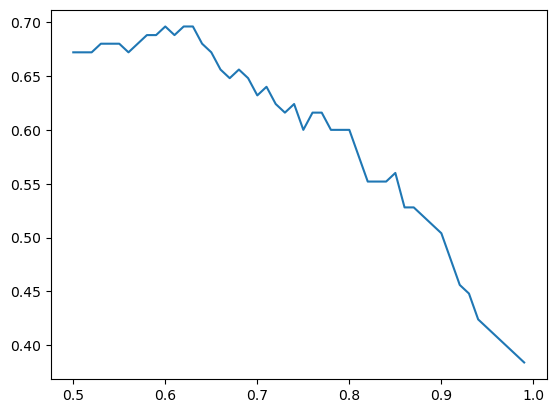

In [14]:
import numpy as np
from matplotlib import pyplot as plt

accuracy_lst = []

for threshold in np.arange(0.5, 1.0, 0.01):
    answers = [int(value) for value in np.array(preds) > threshold]
    accuracy_lst.append((np.array(labels) == np.array(answers)).mean())

print(max(accuracy_lst))

plt.plot(np.arange(0.5, 1.0, 0.01), accuracy_lst)

In [106]:
ce, acc

([tensor(384.4788, device='cuda:0')], [tensor(0.5600, device='cuda:0')])

In [15]:
from evaluate import load
bertscore = load("bertscore")

results = bertscore.compute(predictions=batch["hyp"], references=batch["src"], lang="en")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import torch

preds_bert = torch.tensor(results["f1"])

In [19]:
cross_entropy(preds_bert, label.float())

tensor(385.8892)

In [20]:
calculate_acc(preds_bert, label)

tensor(0.6400)

0.656


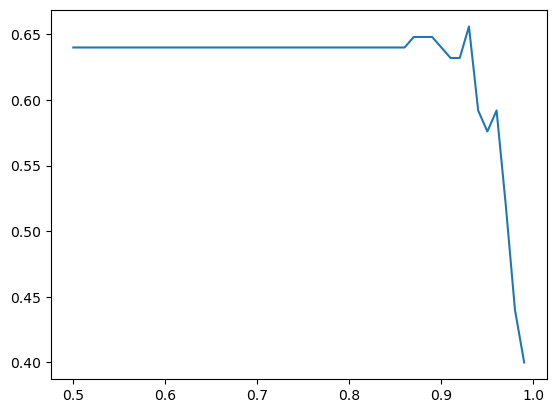

In [21]:
accuracy_lst = []

for threshold in np.arange(0.5, 1.0, 0.01):
    answers = [int(value) for value in np.array(preds_bert) > threshold]
    accuracy_lst.append((np.array(labels) == np.array(answers)).mean())

print(max(accuracy_lst))

plt.plot(np.arange(0.5, 1.0, 0.01), accuracy_lst)